Running a tobit style regression in Stan.

In [1]:
# set up Python
from typing import Iterable
import logging
import numpy as np
import pandas as pd
from plotnine import *
from cmdstanpy import CmdStanModel
from sklearn.linear_model import LinearRegression

# quiet down Stan
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())

In [2]:
rng = np.random.default_rng(2024)

In [3]:
# from 
# https://win-vector.com/2024/08/16/post-hoc-adjustment-for-zero-thresholded-linear-models/
def true_process(mu: float = 0.0, N: int = 500):
  x = 3 * rng.normal(size=N, loc=mu)
  f_x = x / np.e - 1
  y = np.maximum(0.0, f_x + 0.5 * rng.normal(size=N))
  y_ideal = np.maximum(0.0, f_x)
  df = pd.DataFrame({
    'x': x, 
    'y': y, 
    'y_ideal': y_ideal,
    })
  return df

d_train = true_process()
d_test = true_process()


d_train

,x,y,y_ideal
0,3.086571,0.000000,0.135486
1,4.925760,0.901341,0.812086
2,3.440159,0.507536,0.265564
3,-2.919539,0.000000,0.000000
4,-4.178400,0.000000,0.000000
...,...,...,...
495,-0.125290,0.000000,0.000000
496,3.975848,0.208396,0.462633
497,-3.384108,0.000000,0.000000
498,2.888455,0.000000,0.062603


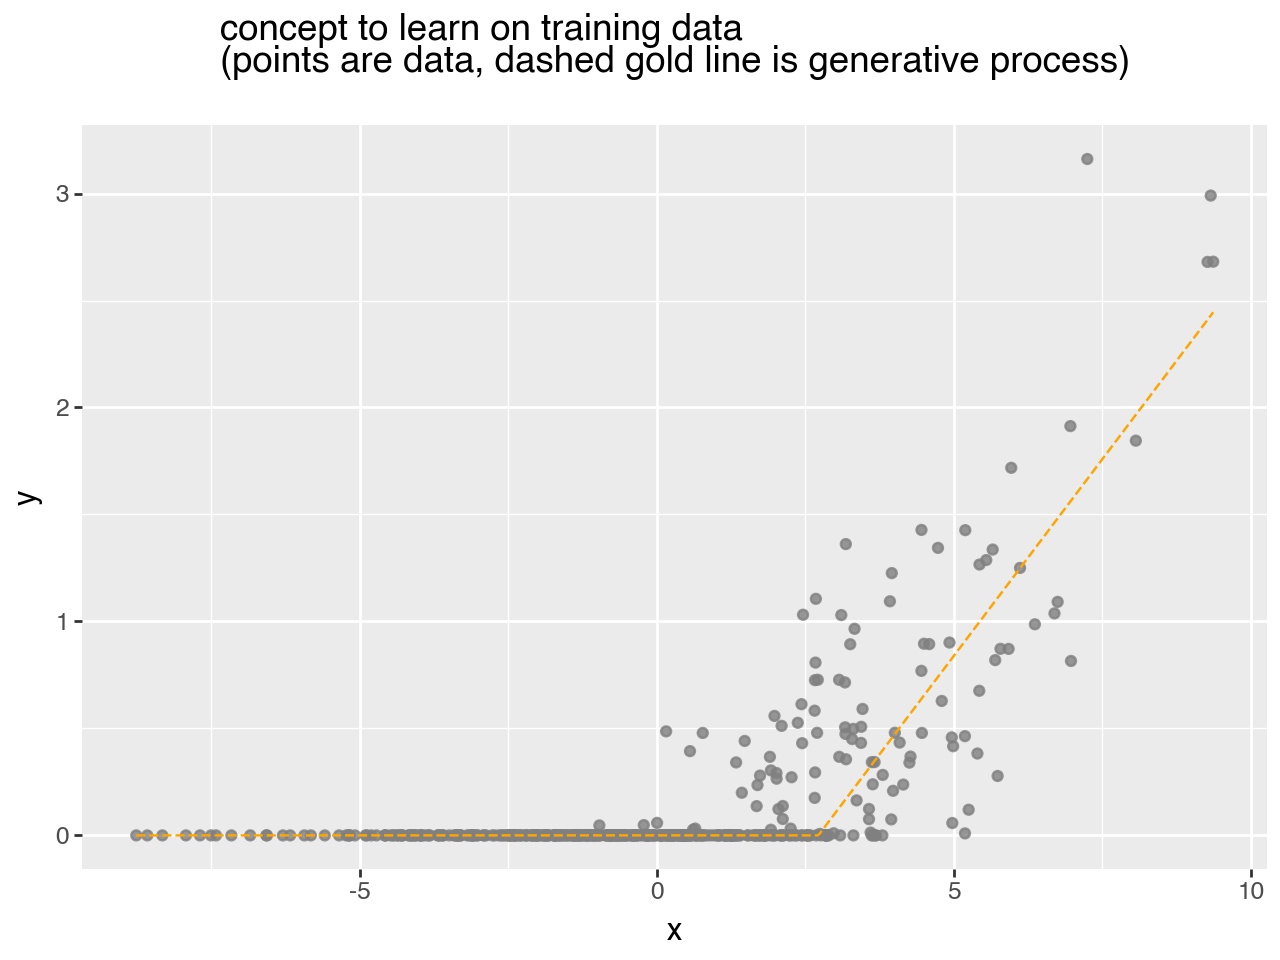

In [4]:
(
    ggplot(
        data=d_train, 
        mapping=aes(x='x')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) + 
    geom_line(
        mapping=aes(y='y_ideal'),
        color="orange", linetype='--') + 
    ggtitle("""concept to learn on training data
(points are data, dashed gold line is generative process)
""")
)

In [5]:

lm0 = LinearRegression()
lm0.fit(
    d_train.loc[:, ['x']],
    d_train.loc[:, 'y'],
)

d_test['ypred0'] = np.maximum(
    0, 
    lm0.predict(d_test.loc[:, ['x']]))

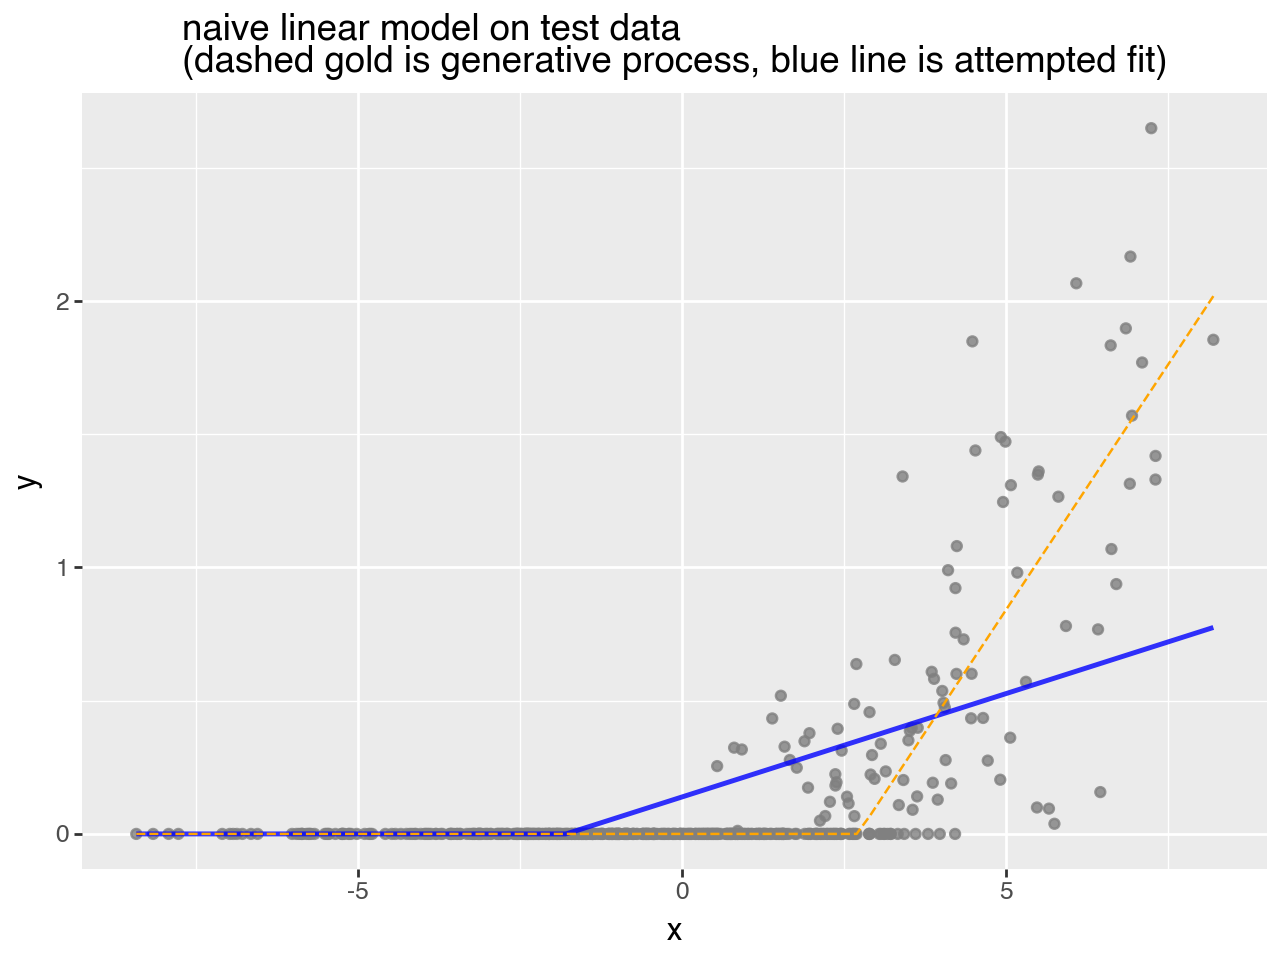

In [6]:
(
    ggplot(
        data=d_test, 
        mapping=aes(x='x')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) + 
    geom_line(
        mapping=aes(y='ypred0'),
        color="blue",
        alpha=0.8,
        size=1) + 
    geom_line(
        mapping=aes(y='y_ideal'),
        color="orange", linetype='--') + 
    ggtitle("""naive linear model on test data
(dashed gold is generative process, blue line is attempted fit)""")
)

In [7]:
# specify our Stan model, as a pure criticism of proposed solutions
stan_model_criticism_src = """
data {
  int<lower=1> n_vars;               // number of explanatory variables
  int<lower=0> m_positive;           // number of positive observations
  int<lower=0> m_zero;               // number of zero observations
  matrix[m_positive, n_vars] x_pos;  // explanatory variable for positive outcomes
  vector[m_positive] y_pos;          // observed positive outcomes
  matrix[m_zero, n_vars] x_zero;     // explanatory variable for non-positive outcomes
}
parameters {
  vector[n_vars] a;                  // regression slope(s)
  real b;                            // regression intercept
  real<lower=0> sigma;               // variance / noise level
}
model {
  target += normal_lpdf(y_pos | x_pos * a + b, sigma);
  target += normal_lcdf(0 | x_zero * a + b, sigma);
}
"""

# target += adds to log probability, and stan maximizes
# see https://mc-stan.org/docs/2_18/reference-manual/increment-log-prob-section.html

In [8]:
# organize training data for export
pos_positions = d_train['y'] > 0
x_pos = [[x] for x in d_train['x'][pos_positions]]
y_pos = list(d_train['y'][pos_positions])
x_zero = [[x] for x in d_train['x'][pos_positions == False]]

data_str = f"""
{{
    "n_vars" : 1,
    "m_positive" : {len(x_pos)},
    "m_zero" : {len(x_zero)},
    "x_pos" : {x_pos},
    "y_pos" : {y_pos},
    "x_zero" : {x_zero}
}}
"""

# export data
data_file = "tobit_tmp.json"
with open(data_file, 'w', encoding='utf8') as file:
    file.write(data_str)

print(data_str)


{
    "n_vars" : 1,
    "m_positive" : 109,
    "m_zero" : 391,
    "x_pos" : [[4.92576012201345], [3.440158588789841], [5.430856722885849], [2.252530419461755], [1.9192786617943873], [4.453216757051106], [2.4345603509446727], [2.709189233230887], [4.973052165593791], [3.597561496848706], [3.6335834081054097], [1.9029028243320547], [5.5445018859632], [4.005812186246286], [3.4370317016746985], [2.660706213350811], [5.920666020987925], [3.166924631431211], [2.372030148446804], [2.6553923886981328], [6.746424225317705], [6.961060142298645], [0.5578287926290123], [1.2152051516700768], [3.104850451055723], [5.652779100275561], [4.583876345220418], [3.1688990281091662], [1.6939591301816832], [5.965120191296535], [2.670589396708531], [7.245402443506883], [4.251428394394446], [0.6456580862219304], [2.6570134604429745], [5.186585696874835], [5.7842603865958635], [3.570509750396085], [2.676754181552428], [3.3276281449657654], [6.692642203185458], [3.6189871920428356], [3.5707636410773644], [4.0

In [9]:
def run_stan_model(
        stan_model_src: str,
        *,
        stan_file_name: str = 'tmp.stan'): 
    # build model
    with open(stan_file_name, 'w', encoding='utf8') as file:
        file.write(stan_model_src)
    # instantiate the model object
    model = CmdStanModel(stan_file=stan_file_name)

    # perform sampling
    fit = model.sample(
        data=data_file,
        show_progress=False,
        show_console=False,
        )

    # retrieve results
    return fit.draws_pd()

In [10]:
res = run_stan_model(
    stan_model_criticism_src, 
    stan_file_name='criticism_model.stan')

In [11]:
res

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a[1],b,sigma
0,-142.927,0.771002,0.307201,3.0,7.0,0.0,143.416,0.363522,-0.902418,0.536280
1,-144.302,0.944282,0.307201,2.0,3.0,0.0,144.510,0.330004,-0.966778,0.541500
2,-141.468,0.980672,0.307201,2.0,7.0,0.0,144.570,0.335288,-0.883701,0.525266
3,-141.337,0.998097,0.307201,3.0,15.0,0.0,141.785,0.338833,-0.904067,0.525296
4,-141.620,0.997196,0.307201,3.0,15.0,0.0,141.932,0.330705,-0.851103,0.516419
...,...,...,...,...,...,...,...,...,...,...
3995,-141.192,0.999155,0.387453,2.0,7.0,0.0,141.697,0.356326,-0.932948,0.525453
3996,-141.696,0.997672,0.387453,3.0,7.0,0.0,141.869,0.371893,-1.004530,0.543178
3997,-141.855,0.949230,0.387453,3.0,7.0,0.0,142.286,0.358505,-0.989859,0.557348
3998,-144.576,0.889376,0.387453,3.0,7.0,0.0,144.920,0.352165,-0.961627,0.607768


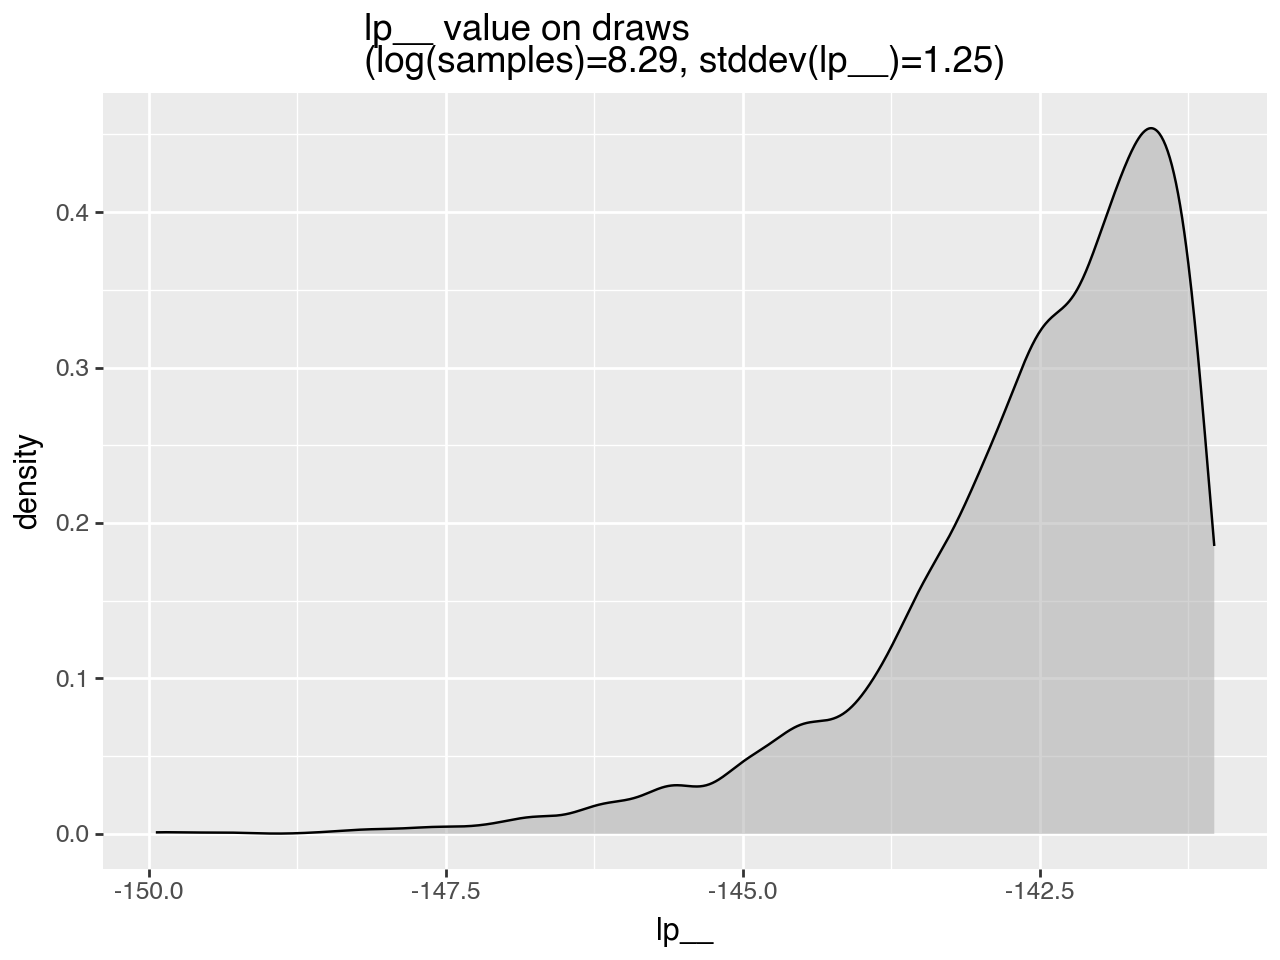

In [12]:
# show distribution of log model criticism
log_n_res = np.log(res.shape[0])
std_lp = np.std(res['lp__'])
(
    ggplot(
        data=res,
        mapping=aes(x='lp__'),
    )
    + geom_density(fill='darkgrey', alpha=0.5)
    + ggtitle(f"""lp__ value on draws
(log(samples)={log_n_res:.2f}, stddev(lp__)={std_lp:.2f})""")
)

In [13]:
(res['a[1]'].mean(), res['b'].mean())

(0.34973057300000004, -0.9242947047500001)

In [14]:
# sample down to more likely returns (not strictly necessary)
res_picked = res.loc[
    res['lp__'] >= np.quantile(res['lp__'], q=0.9), 
    :].reset_index(drop=True, inplace=False)




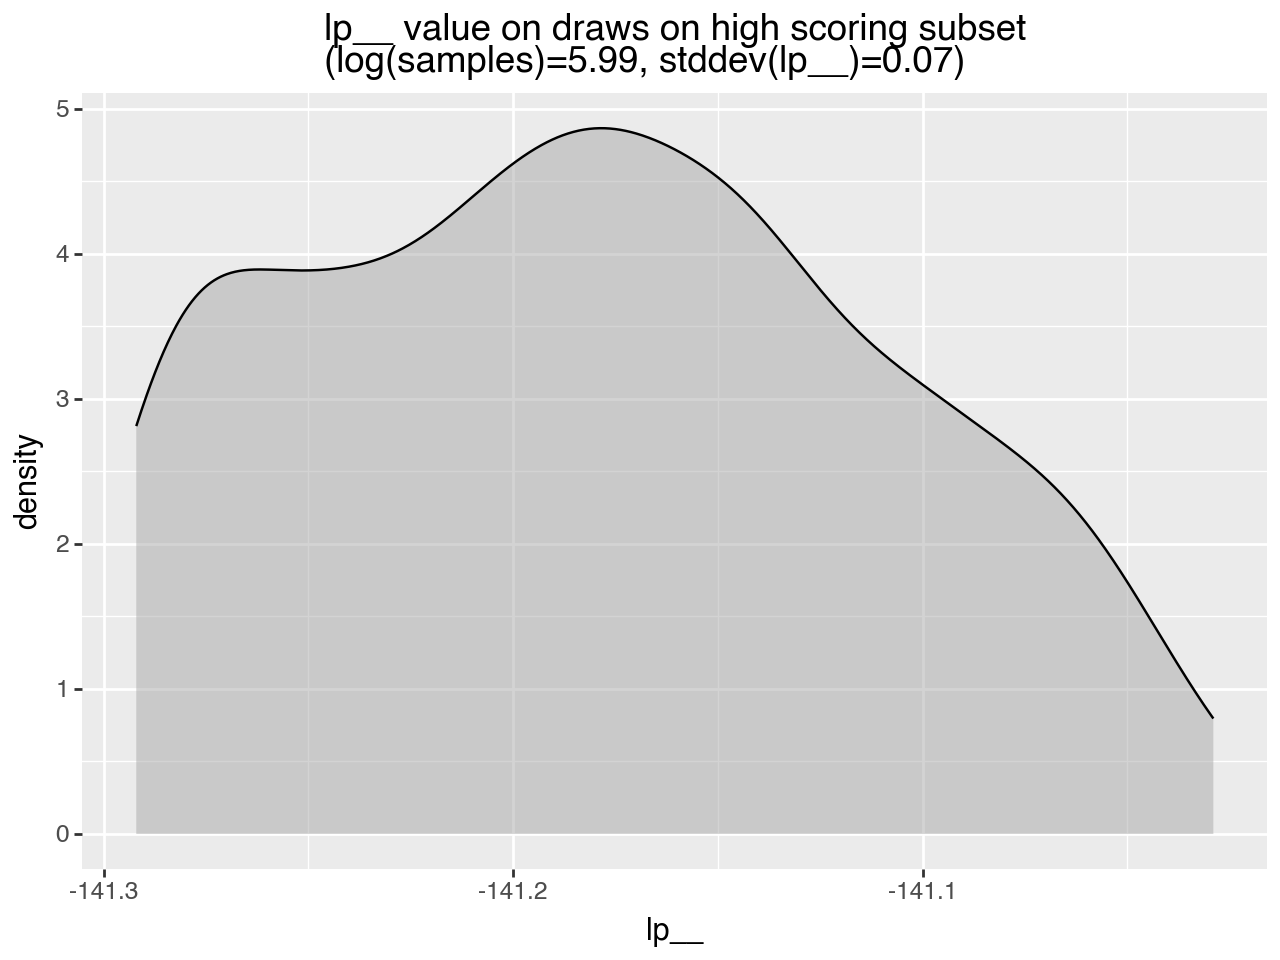

In [15]:
# show distribution of restricted model criticisms
log_n_res_picked = np.log(res_picked.shape[0])
std_lp_picked = np.std(res_picked['lp__'])
(
    ggplot(
        data=res_picked,
        mapping=aes(x='lp__'),
    )
    + geom_density(fill='darkgrey', alpha=0.5)
    + ggtitle(f"""lp__ value on draws on high scoring subset
(log(samples)={log_n_res_picked:.2f}, stddev(lp__)={std_lp_picked:.2f})""")
)

In [16]:
def add_in_predictions_and_plot(res_picked: pd.DataFrame, *, model_name: str):
    # land predictions
    a = res_picked['a[1]'].mean()
    b = res_picked['b'].mean()
    d_test[model_name] = np.maximum(
        0, 
        a * d_test['x'] + b)
    # get upper/lower 1-sd band for predictions (at a 90% quantile of samples)
    evals = np.array([
        np.maximum(
            0, 
            res_picked.loc[i, 'a[1]'] * d_test['x'] + res_picked.loc[i, 'b'] - res_picked.loc[i, 'sigma']) 
            for i in range(res_picked.shape[0])
        ])
    d_test[f'{model_name} q0.1'] = np.quantile(evals, q=0.1, axis=0)
    evals = np.array([
        np.maximum(
            0, 
            res_picked.loc[i, 'a[1]'] * d_test['x'] + res_picked.loc[i, 'b'] + res_picked.loc[i, 'sigma']) 
            for i in range(res_picked.shape[0])
        ])
    d_test[f'{model_name} q0.9'] = np.quantile(evals, q=0.9, axis=0)
    return (
        ggplot(
            data=d_test, 
            mapping=aes(x='x', y='y')) + 
        geom_point(
            mapping=aes(y='y'),
            color="gray", alpha=0.8) +
        geom_line(
            mapping=aes(y=model_name),
            color="blue",
            alpha=0.8,
            size=1) +
        geom_line(
            mapping=aes(y='y_ideal'),
            color="orange", linetype='--') + 
        geom_ribbon(mapping=aes(
            ymin=f'{model_name} q0.1', 
            ymax=f'{model_name} q0.9'), 
            alpha=0.3, fill='blue') +
        ggtitle(f"""{model_name} on test data
(band is 1-sigma modeled distribution of data)""")
    )

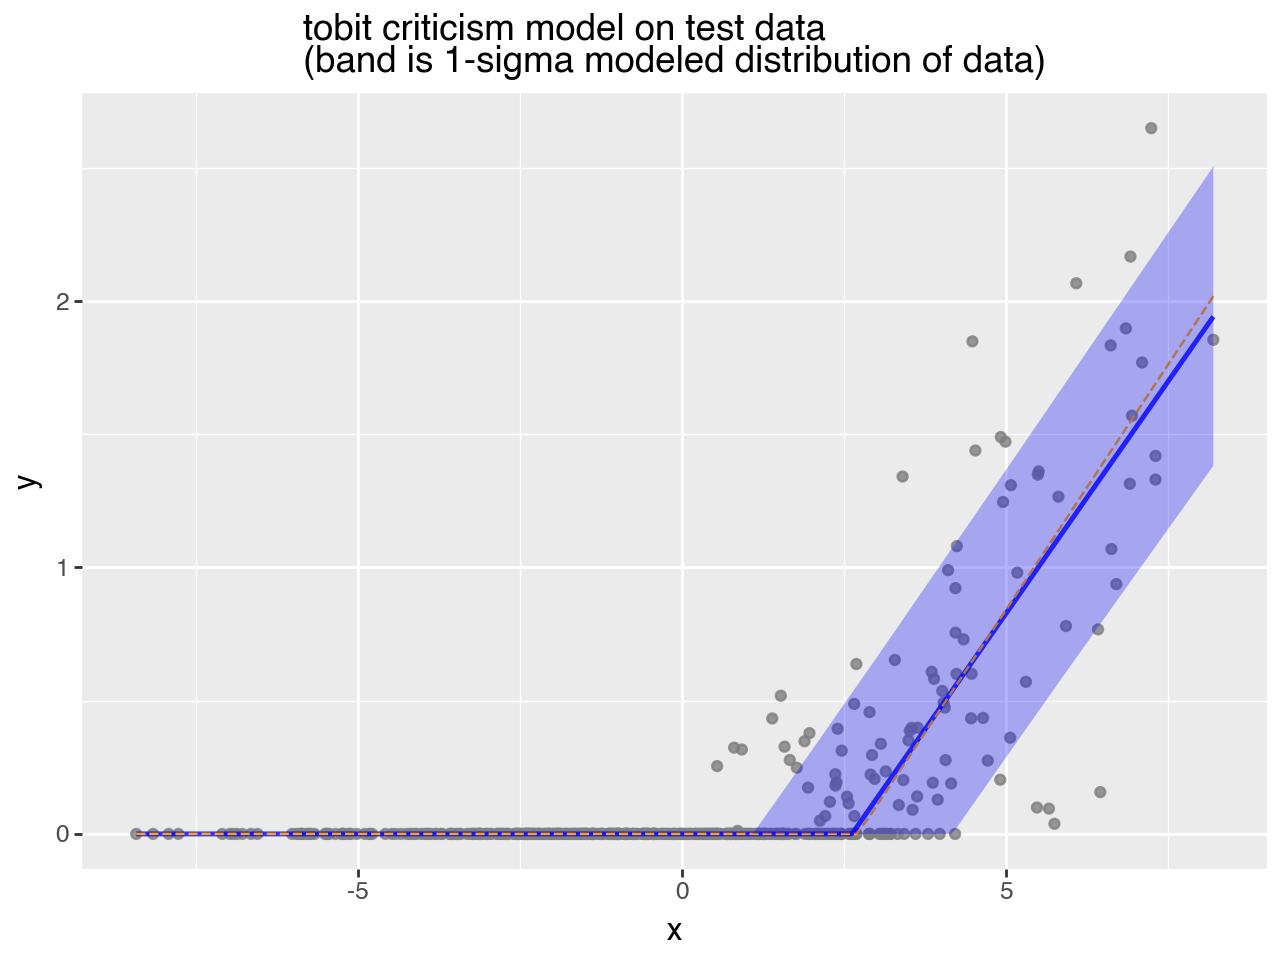

In [17]:
add_in_predictions_and_plot(
    res_picked, 
    model_name="tobit criticism model")

In [18]:

# specify our Stan model in a more distributional manner
stan_model_probability_src = """
data {
  int<lower=1> n_vars;               // number of explanatory variables
  int<lower=0> m_positive;           // number of positive observations
  int<lower=0> m_zero;               // number of zero observations
  matrix[m_positive, n_vars] x_pos;  // explanatory variable for positive outcomes
  vector[m_positive] y_pos;          // observed positive outcomes
  matrix[m_zero, n_vars] x_zero;     // explanatory variable for non-positive outcomes
}
parameters {
  vector[n_vars] a;                  // regression slope(s)
  real b;                            // regression intercept
  real<lower=0> sigma;               // variance / noise level
}
model {
      // basic priors
  a ~ normal(0, 10);
  b ~ normal(0, 10);
  sigma ~ chi_square(10);
      // tobit style model structure
  y_pos ~ normal(x_pos * a + b, sigma);
  target += normal_lcdf(0 | x_zero * a + b, sigma);
}
"""


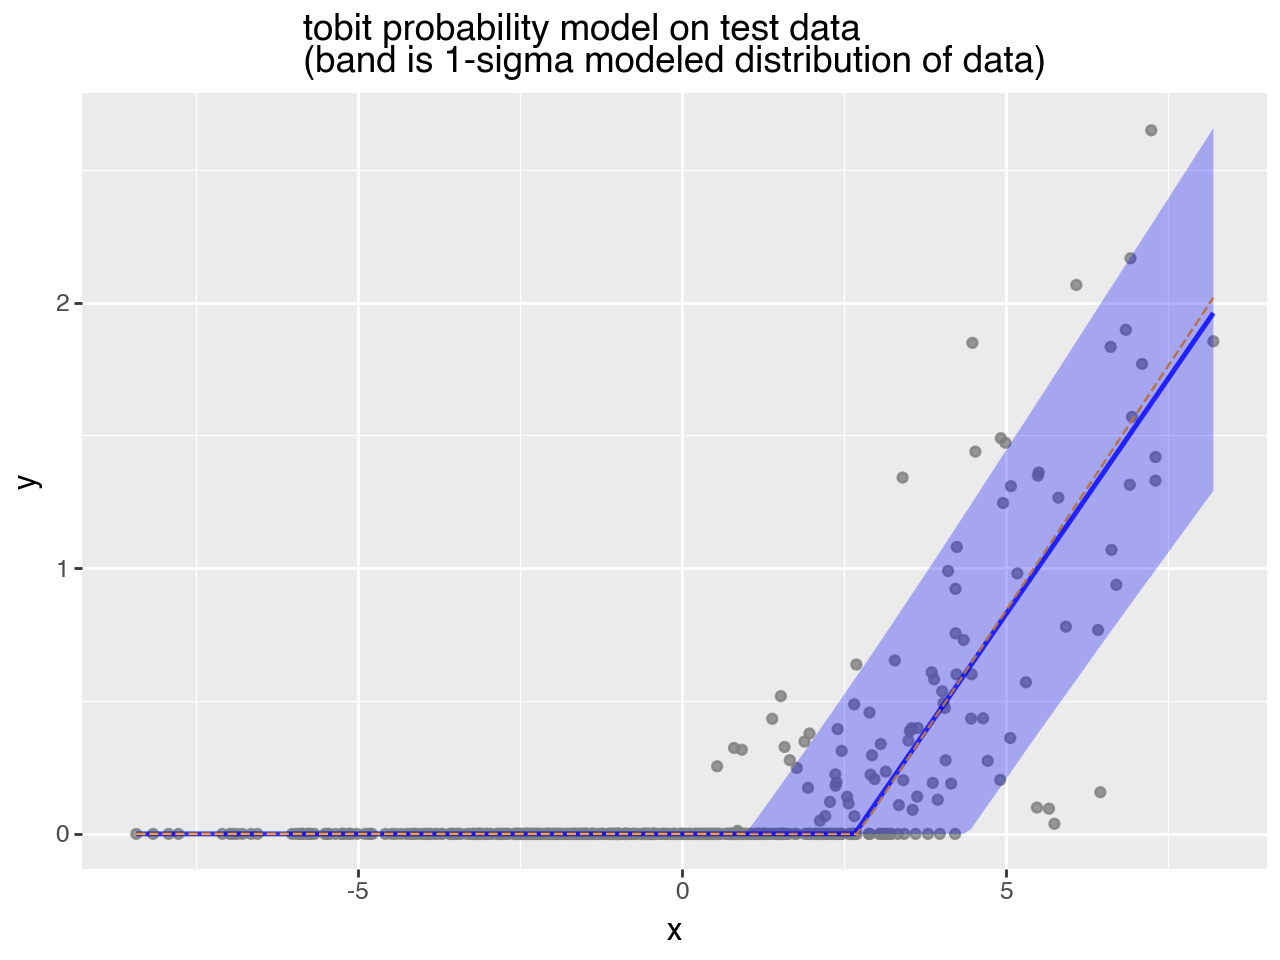

In [19]:
# run again
res_prob = run_stan_model(
    stan_model_probability_src, 
    stan_file_name='probability_model.stan')

add_in_predictions_and_plot(
    res_prob, 
    model_name="tobit probability model")